## Description

We solve the Neoclassical Growth Model with Capital(k) and Productivity (y):
\begin{align}
  \rho V(k,y) &= \max_{c} [ u(c) +  \partial_k V (F(k,y)-\delta k - c) + \mu(y)\partial_y V(k,y) + \frac{\sigma^2(y)}{2} \partial_{yy}  V(k,y) ] \\
  &u(c) = \frac{c^{1-\sigma}}{1-\sigma}, ~~~
  F(k)=y k^\alpha, ~~~
  dy_t=\mu d_t+\sigma dz_t
\end{align}


## Import

In [1]:
import numpy as np
from numpy import linalg

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Parameters

In [2]:
"""PROBLEM PARAMETERS"""
sigma = 2 # 1 changes to log utility
alpha = 0.3
delta = 0.05
rho = 0.05

"""PRODUCTIVITY DOMAIN"""
# ORNSTEIN-UHLENBECK PROCESS dlog(z) = -theta*log(z)dt + sig2*dW
# STATIONARY DISTRIBUTION IS log(z) ~ N(0,Var) WHERE Var = sig2/(2*theta)
Var = 0.07
zmean = np.exp(Var/2) #MEAN OF LOG-NORMAL DISTRIBUTION N(0,Var)
Corr = 0.9
theta = -np.log(Corr) # this is mu
sig2 = 2*theta*Var # this is sigma

ymin = zmean*0.8
ymax = zmean*1.2

print("ymin:",ymin)
print("ymax:",ymax)

#DRIFT (FROM ITO'S LEMMA)
def mu(y):
    return (-theta*np.log(y) + sig2/2)*y 

# VARIANCE (FROM ITO'S LEMMA)
def sigma2(y):
    return sig2*y**2

"""CAPITAL DOMAIN"""
kss = (alpha/(rho+delta))**(1/(1-alpha))
kmin = 0.001*kss
kmax = 2*kss
print("kmin:",kmin)
print("kmax:",kmax)

train_num = 100
test_num = (train_num*2)-1
"""USE RANDOM INPUT"""
# k_train = np.random.uniform(kmin,kmax,(train_num,1))
# y_train = np.random.uniform(ymin,ymax,(train_num,1))

"""USE UNIFORM INPUT"""
#intervals
k_interval = np.linspace(kmin, kmax, num=train_num).reshape(train_num,1)
y_interval = np.linspace(ymin, ymax, num=train_num).reshape(train_num,1)
k_grid, y_grid = np.meshgrid(k_interval, y_interval)

"""NORMALIZED INPUT"""
# k_norm = (k_train-kmin)/(kmax-kmin)
# y_norm = (y_train-ymin)/(ymax-ymin)
# k_grid, y_grid = np.meshgrid(k_norm, y_norm)

"""RESTRUCTURE INPUT"""
#for NN
ky_train = np.dstack([k_grid, y_grid]).reshape(-1, 2)
#for plotting
k_train, y_train = np.hsplit(ky_train, 2)

"""INITIAL GUESS"""
def guess(ky_list) :
    length=len(ky_list)
    output = np.zeros(length)
    for i in range(length):
        value = - 11/81*(ky_list[i,0] - 9)**2 - 13 + 10*(ky_list[i,1] - 1)
        output[i] = value
    return output

"""ITERATION PARAMETERS"""
dt = 5*1e-2     # this is the learning rate for TD Reinforcement Learning
criteria = 1e-2
numIterations = 200

ymin: 0.8284957670396986
ymax: 1.242743650559548
kmin: 0.0048039866566730914
kmax: 9.607973313346182


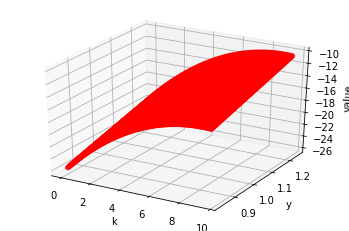

In [3]:
v_train = guess(ky_train)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(k_train, y_train, v_train, c='r', marker='o')

ax.set_xlabel('k')
ax.set_ylabel('y')
ax.set_zlabel('value')

plt.show()

## Architecture

In [4]:
def build_model():
    model = keras.Sequential([
        layers.Dense(20, activation='tanh', input_shape=(2,)),
        layers.Dense(20, activation='tanh'),     
        layers.Dense(20, activation='tanh'),   
        layers.Dense(1) 
    ])
    
    optimizer = tf.keras.optimizers.SGD(lr=1e-3)

#   optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#   optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(optimizer=optimizer,
                  loss='mse')
    return model

In [5]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 921
Trainable params: 921
Non-trainable params: 0
_________________________________________________________________


## Train on initial guess 

In [6]:
model.fit(ky_train, v_train, epochs=50, verbose=1) 

Epoch 1/50
10000/10000 [==============================] - 0s 43us/sample - loss: 21.9367
Epoch 2/50
10000/10000 [==============================] - 0s 31us/sample - loss: 4.1555
Epoch 3/50
10000/10000 [==============================] - 0s 33us/sample - loss: 2.1756
Epoch 4/50
10000/10000 [==============================] - 0s 32us/sample - loss: 1.8769
Epoch 5/50
10000/10000 [==============================] - 0s 31us/sample - loss: 1.5939
Epoch 6/50
10000/10000 [==============================] - 0s 32us/sample - loss: 1.2581
Epoch 7/50
10000/10000 [==============================] - 0s 32us/sample - loss: 1.0072
Epoch 8/50
10000/10000 [==============================] - 0s 31us/sample - loss: 0.9459
Epoch 9/50
10000/10000 [==============================] - 0s 31us/sample - loss: 0.7485
Epoch 10/50
10000/10000 [==============================] - 0s 32us/sample - loss: 0.6664
Epoch 11/50
10000/10000 [==============================] - 0s 32us/sample - loss: 0.5876
Epoch 12/50
10000/10000 [====

0.29466224515930733


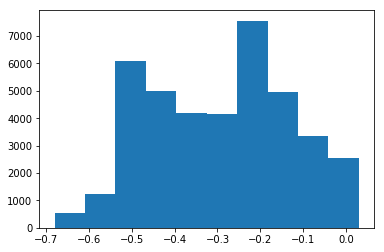

In [7]:
"""TEST WITH UNIFORM INPUT"""
k_Tinterval = np.linspace(kmin, kmax, num=test_num).reshape(test_num,1)
y_Tinterval = np.linspace(ymin, ymax, num=test_num).reshape(test_num,1)
k_Tgrid, y_Tgrid = np.meshgrid(k_Tinterval, y_Tinterval)

"""TEST WITH NORMALIZED INPUT"""
# k_Tnorm = (k_test-kmin)/(kmax-kmin)
# y_Tnorm = (y_test-ymin)/(ymax-ymin)
# k_grid, y_grid = np.meshgrid(k_Tnorm, y_Tnorm)

"""RESTRUCTURE INPUT"""
#for NN
ky_test = np.dstack([k_Tgrid, y_Tgrid]).reshape(-1, 2)
#for plotting
k_test, y_test = np.hsplit(ky_test, 2)

v_test = guess(ky_test)

error = v_test.reshape(test_num**2,1) - model.predict([ky_test])

print(np.mean(abs(error)))

plt.hist(error, bins=10) 
plt.show()

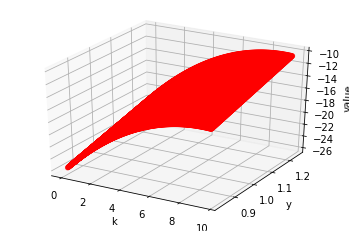

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(k_test, y_test, v_test, c='r', marker='o')

ax.set_xlabel('k')
ax.set_ylabel('y')
ax.set_zlabel('value')

plt.show()

In [9]:
update = 1      
converge_error = 10

normInf_history = []
norm1_history = []
norm2_history = []
mean_history = []

inputs = tf.Variable(ky_train)

while converge_error > criteria and update < numIterations:
        value = model.predict([ky_train])
          
        with tf.GradientTape() as t1:
            with tf.GradientTape() as t2:
                output = model(inputs)
            dV1 = t2.gradient(output, inputs)
        dV2 = t1.gradient(dV1, inputs).numpy()

        [dV_dk,dV_dy] = np.hsplit(dV1, 2)
        [d2V_dk2,d2V_dy2] = np.hsplit(dV2, 2)

        for i in range(train_num**2):
            dV_dk[i] = np.maximum(dV_dk[i], 1e-4)
            
        # with sigma=2 CRRA utility function
        HJB = (1/np.sqrt(dV_dk))**(1-sigma)/(1-sigma)\
                +dV_dk*(y_train*(k_train)**alpha-delta*k_train-1/np.sqrt(dV_dk))\
                +mu(y_train)*dV_dy +1/2*sigma2(y_train)*d2V_dy2 - rho*value

        value += dt*HJB
        model.fit(ky_train, value,  epochs=10, verbose=0)
        
        normInf = max(abs(HJB))
        norm1 = linalg.norm(HJB,1)
        norm2 = linalg.norm(HJB)
        meanErr = np.mean(abs(HJB))
        
        normInf_history.append(normInf)
        norm1_history.append(norm1)
        norm2_history.append(norm2)
        mean_history.append(meanErr)
        
        print("update: ", update)
        print("\t infNorm =", normInf)
        print("\t 1Norm = ", norm1)
        print("\t 2Norm = ", norm2)
        print("\t mean abs = ", meanErr)
        
        update += 1
        

update:  1
	 infNorm = [1.56772662]
	 1Norm =  2366.6831953223013
	 2Norm =  28.75467587188943
	 mean abs =  0.23666831953223014
update:  2
	 infNorm = [1.59022562]
	 1Norm =  2352.9963382894794
	 2Norm =  28.66360232897455
	 mean abs =  0.23529963382894795
update:  3
	 infNorm = [1.61227088]
	 1Norm =  2340.793298653553
	 2Norm =  28.585584044785783
	 mean abs =  0.2340793298653553
update:  4
	 infNorm = [1.63433138]
	 1Norm =  2327.8210881182677
	 2Norm =  28.49982416338171
	 mean abs =  0.23278210881182676
update:  5
	 infNorm = [1.6553789]
	 1Norm =  2315.9020472951843
	 2Norm =  28.425494142647164
	 mean abs =  0.23159020472951844
update:  6
	 infNorm = [1.67681184]
	 1Norm =  2303.7400133928286
	 2Norm =  28.35512196601138
	 mean abs =  0.23037400133928285
update:  7
	 infNorm = [1.69784132]
	 1Norm =  2292.027646475739
	 2Norm =  28.290269133269096
	 mean abs =  0.2292027646475739
update:  8
	 infNorm = [1.71879836]
	 1Norm =  2280.841698006385
	 2Norm =  28.23569958713776
	 mea

update:  65
	 infNorm = [2.75090901]
	 1Norm =  1824.928695993516
	 2Norm =  31.833156997815475
	 mean abs =  0.1824928695993516
update:  66
	 infNorm = [2.7654347]
	 1Norm =  1823.609763237153
	 2Norm =  32.0334380686693
	 mean abs =  0.18236097632371528
update:  67
	 infNorm = [2.78196003]
	 1Norm =  1818.8977205989054
	 2Norm =  32.20766126668076
	 mean abs =  0.18188977205989054
update:  68
	 infNorm = [2.79908996]
	 1Norm =  1813.6754949949482
	 2Norm =  32.38264651485111
	 mean abs =  0.18136754949949482
update:  69
	 infNorm = [2.81470851]
	 1Norm =  1810.869307877752
	 2Norm =  32.58799625918637
	 mean abs =  0.18108693078777519
update:  70
	 infNorm = [2.83189779]
	 1Norm =  1805.8714522992282
	 2Norm =  32.76568381466438
	 mean abs =  0.1805871452299228
update:  71
	 infNorm = [2.84923167]
	 1Norm =  1801.0625724218605
	 2Norm =  32.944408641936434
	 mean abs =  0.18010625724218604
update:  72
	 infNorm = [2.86694193]
	 1Norm =  1794.960070688533
	 2Norm =  33.10751736861392


update:  129
	 infNorm = [3.31517402]
	 1Norm =  1622.584725344851
	 2Norm =  47.26992716644829
	 mean abs =  0.1622584725344851
update:  130
	 infNorm = [3.30586348]
	 1Norm =  1620.772362347128
	 2Norm =  47.52492935158984
	 mean abs =  0.1620772362347128
update:  131
	 infNorm = [3.30246011]
	 1Norm =  1614.9700657768278
	 2Norm =  47.647754029956815
	 mean abs =  0.1614970065776828
update:  132
	 infNorm = [3.28874617]
	 1Norm =  1614.2262444306443
	 2Norm =  47.915521770570294
	 mean abs =  0.16142262444306443
update:  133
	 infNorm = [3.26499458]
	 1Norm =  1617.9814045639926
	 2Norm =  48.343750207812555
	 mean abs =  0.16179814045639926
update:  134
	 infNorm = [3.25699086]
	 1Norm =  1612.2341403424307
	 2Norm =  48.481686730480995
	 mean abs =  0.16122341403424306
update:  135
	 infNorm = [3.30657087]
	 1Norm =  1612.9538832034987
	 2Norm =  48.80213758064912
	 mean abs =  0.16129538832034987
update:  136
	 infNorm = [3.35123445]
	 1Norm =  1607.884230353011
	 2Norm =  48.875

update:  192
	 infNorm = [5.03767801]
	 1Norm =  1158.0070971881748
	 2Norm =  42.62444302651316
	 mean abs =  0.11580070971881748
update:  193
	 infNorm = [5.01988785]
	 1Norm =  1144.7788159704594
	 2Norm =  42.133766257779
	 mean abs =  0.11447788159704594
update:  194
	 infNorm = [4.99092459]
	 1Norm =  1131.2024505688482
	 2Norm =  41.55768463423213
	 mean abs =  0.11312024505688482
update:  195
	 infNorm = [4.93951703]
	 1Norm =  1118.2686056510058
	 2Norm =  40.818348343725546
	 mean abs =  0.11182686056510058
update:  196
	 infNorm = [4.88844775]
	 1Norm =  1106.4808932214014
	 2Norm =  40.08541789241031
	 mean abs =  0.11064808932214014
update:  197
	 infNorm = [4.87974895]
	 1Norm =  1099.8918975674108
	 2Norm =  39.68254672723432
	 mean abs =  0.10998918975674107
update:  198
	 infNorm = [4.81113691]
	 1Norm =  1087.2869369465573
	 2Norm =  38.81555786027803
	 mean abs =  0.10872869369465572
update:  199
	 infNorm = [4.82823302]
	 1Norm =  1084.628614832146
	 2Norm =  38.635

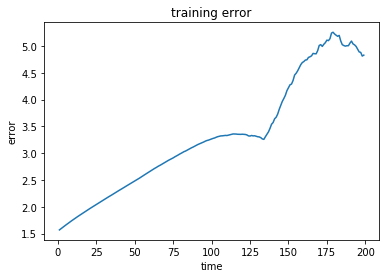

In [10]:
error_history = normInf_history
x = np.linspace(1, len(error_history), num=len(error_history))
y = np.array(error_history)

plt.plot(x,y)

plt.xlabel('time')
plt.ylabel('error')
plt.title('training error')
plt.show()

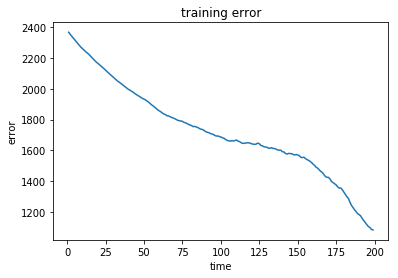

In [11]:
error_history = norm1_history
x = np.linspace(1, len(error_history), num=len(error_history))
y = np.array(error_history)

plt.plot(x,y)

plt.xlabel('time')
plt.ylabel('error')
plt.title('training error')
plt.show()

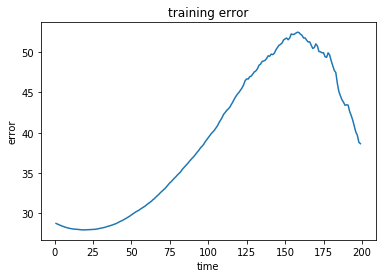

In [12]:
error_history = norm2_history
x = np.linspace(1, len(error_history), num=len(error_history))
y = np.array(error_history)

plt.plot(x,y)

plt.xlabel('time')
plt.ylabel('error')
plt.title('training error')
plt.show()

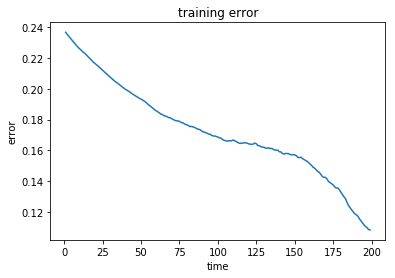

In [13]:
error_history = mean_history
x = np.linspace(1, len(error_history), num=len(error_history))
y = np.array(error_history)

plt.plot(x,y)

plt.xlabel('time')
plt.ylabel('error')
plt.title('training error')
plt.show()

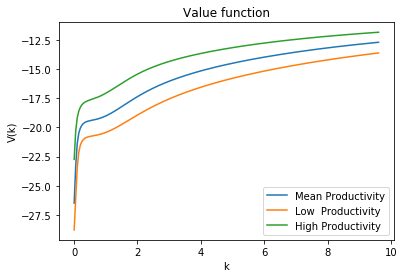

In [16]:
y_mean = np.ones(test_num).reshape(test_num,1)
y_low  = ymin*np.ones(test_num).reshape(test_num,1)
y_high = ymax*np.ones(test_num).reshape(test_num,1)

z_mean = model.predict([np.concatenate((k_Tinterval, y_mean), axis=1)])
z_low  = model.predict([np.concatenate((k_Tinterval, y_low ), axis=1)])
z_high = model.predict([np.concatenate((k_Tinterval, y_high), axis=1)])

plt.plot(k_Tinterval,z_mean,label='Mean Productivity')
plt.plot(k_Tinterval,z_low, label='Low  Productivity')
plt.plot(k_Tinterval,z_high,label='High Productivity')

plt.legend()
plt.xlabel('k')
plt.ylabel('V(k)')
plt.title('Value function')
plt.show()

## Write to file

In [17]:
np.savetxt("prediction.csv", model.predict([ky_test]), delimiter=",")
np.savetxt("domain.csv", ky_test, delimiter=",")
np.savetxt("error.csv", norm1_history, delimiter=",")

np.savetxt("z_mean.csv", z_mean, delimiter=",")
np.savetxt("z_low.csv", z_low, delimiter=",")
np.savetxt("z_high.csv", z_high, delimiter=",")
np.savetxt("k_test_interval.csv", k_Tinterval, delimiter=",")


In [20]:
y_high

array([[1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.24274365],
       [1.242